<a href="https://colab.research.google.com/github/thisisindrajit/Using-Deep-CNN-to-enhance-low-res-photos-to-match-the-quality-of-DSLR-cameras/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# References and citation

This notebook contains references for code from this repository: https://github.com/aiff22/DPED.git

**This project is for educational purposes only.**

<br>
<hr>
<br>

Citation:

<pre>
@inproceedings{ignatov2017dslr,
  title={DSLR-Quality Photos on Mobile Devices with Deep Convolutional Networks},
  author={Ignatov, Andrey and Kobyshev, Nikolay and Timofte, Radu and Vanhoey, Kenneth and Van Gool, Luc},
  booktitle={Proceedings of the IEEE International Conference on Computer Vision},
  pages={3277--3285},
  year={2017}
}
</pre>



# Imports

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#%tensorflow_version 1.x
!pip install -U tensorflow-addons

import numpy as np
import imageio
import PIL #pillow
import cv2
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras
from __future__ import print_function
import scipy
import scipy.io
import os
import sys
import scipy.stats as st
import matplotlib.pyplot as plt
from scipy import signal
from scipy.ndimage.filters import convolve
from PIL import Image
from functools import reduce

#tensorflow version
print(tf.__version__)

tf.compat.v1.disable_v2_behavior() #to disable tensorflow v2 behavior

     |████████████████████████████████| 706kB 15.4MB/s 
2.4.1
Instructions for updating:
non-resource variables are not supported in the long term


# Arguments

In [ ]:
phone = "iphone"
dped_dir = "drive/MyDrive/Innovation_Practices_Lab/dped_small/"

#arguments for training
train_size = 6000 #the number of training patches randomly loaded each eval_step iterations
learning_rate = 5e-4
num_train_iters = 10000
w_content = 10
w_color = 0.5
w_texture = 1
w_tv = 2000
vgg_dir = "drive/MyDrive/Innovation_Practices_Lab/vgg_pretrained/imagenet-vgg-verydeep-19.mat"
eval_step = 1000
PATCH_HEIGHT = 100
PATCH_WIDTH = 100
PATCH_SIZE = PATCH_WIDTH * PATCH_HEIGHT * 3
batch_size = 50

#arguments for testing
test_subset = "all"
resolution = "orig"

np.random.seed(0)

# Loading the dataset

In [ ]:
#helper functions to load batch training data and test data

#function to load test data
def load_test_data(phone, dped_dir, IMAGE_SIZE):

    #print(phone + " " + dped_dir + " " + str(IMAGE_SIZE))
    
    test_directory_phone = dped_dir + str(phone) + '/test_data/patches/' + str(phone) + '/' #input
    test_directory_dslr = dped_dir + str(phone) + '/test_data/patches/canon/' #target output

    #finding no of test images
    NUM_TEST_IMAGES = len([name for name in os.listdir(test_directory_phone)
                           if os.path.isfile(os.path.join(test_directory_phone, name))])

    #empty arrays with no of rows = number of test images and no of columns = 100*100*3
    test_data = np.zeros((NUM_TEST_IMAGES, IMAGE_SIZE))
    test_answ = np.zeros((NUM_TEST_IMAGES, IMAGE_SIZE))

    for i in range(0,NUM_TEST_IMAGES):
        
        I = np.asarray(imageio.imread(test_directory_phone + str(i) + '.jpg'))
        I = np.float16(np.reshape(I, [1, IMAGE_SIZE]))/255
        test_data[i, :] = I
        
        I = np.asarray(imageio.imread(test_directory_dslr + str(i) + '.jpg'))
        I = np.float16(np.reshape(I, [1, IMAGE_SIZE]))/255
        test_answ[i, :] = I

        if i % 100 == 0:
            print(str(round(i * 100 / NUM_TEST_IMAGES)) + "% done")

    return test_data, test_answ

#function to load training data
def load_batch(phone, dped_dir, TRAIN_SIZE, IMAGE_SIZE):

    #print(phone + " " + dped_dir + " " + IMAGE_SIZE)

    train_directory_phone = dped_dir + str(phone) + '/training_data/' + str(phone) + '/'
    train_directory_dslr = dped_dir + str(phone) + '/training_data/canon/'

    #finding no of training images
    NUM_TRAINING_IMAGES = len([name for name in os.listdir(train_directory_phone)
                               if os.path.isfile(os.path.join(train_directory_phone, name))])

    #if TRAIN_SIZE == -1 then load all images
    if TRAIN_SIZE == -1:
        TRAIN_SIZE = NUM_TRAINING_IMAGES
        #here np.arange returns an array with values from 0 to TRAIN_SIZE-1 -> [0,1,2,3.....]
        TRAIN_IMAGES = np.arange(0, TRAIN_SIZE)
    else:
        #randomly selecting TRAIN_SIZE no of images from total no of training images
        TRAIN_IMAGES = np.random.choice(np.arange(0, NUM_TRAINING_IMAGES-1), TRAIN_SIZE, replace=False)

    #empty arrays with no of rows = number of training images and no of columns = 100*100*3
    train_data = np.zeros((TRAIN_SIZE, IMAGE_SIZE))
    train_answ = np.zeros((TRAIN_SIZE, IMAGE_SIZE))

    i = 0

    for img in TRAIN_IMAGES:

        I = np.asarray(imageio.imread(train_directory_phone + str(img) + '.jpg'))
        I = np.float16(np.reshape(I, [1, IMAGE_SIZE])) / 255
        train_data[i, :] = I

        I = np.asarray(imageio.imread(train_directory_dslr + str(img) + '.jpg'))
        I = np.float16(np.reshape(I, [1, IMAGE_SIZE])) / 255
        train_answ[i, :] = I

        i += 1
        if i % 100 == 0:
            print(str(round(i * 100 / TRAIN_SIZE)) + "% done")

    return train_data, train_answ

In [ ]:
# test_data, test_answ = load_test_data(phone, dped_dir, PATCH_SIZE)
# train_data, train_answ = load_batch(phone, dped_dir, 30, PATCH_SIZE)
# train_data = train_data.reshape(-1, 100,100,3)
# train_answ = train_answ.reshape(-1, 100,100,3)
# test_data = test_data.reshape(-1, 100,100,3)
# test_answ = test_answ.reshape(-1, 100,100,3)


# #training dataset
# for i in range(20):
#   plt.subplot(4,5,i+1)
#   plt.imshow(train_data[i])
#   plt.axis("off")

In [ ]:
# #test dataset
# for i in range(20):
#   plt.subplot(4,5,i+1)
#   plt.imshow(train_answ[i])
#   plt.axis("off")

# VGG 19 pretrained model (conversion of MATLAB file to Neural Network)

In [ ]:
#helper functions for vgg 19 conversion

def conv_layer_vgg(input, weights, bias):
  conv = tf.nn.conv2d(input, tf.constant(weights), strides=(1, 1, 1, 1), padding='SAME')
  return tf.nn.bias_add(conv, bias)

def pool_layer_vgg(input):
  return tf.nn.max_pool(input, ksize=(1, 2, 2, 1), strides=(1, 2, 2, 1), padding='SAME')

def preprocess(image):
  return image - IMAGE_MEAN

#------------------------------------------------------------------

IMAGE_MEAN = np.array([123.68 ,  116.779,  103.939])

#conversion of matlab file to neural network
def net(path_to_vgg_net, input_image):

  layers = (
      'conv1_1', 'relu1_1', 'conv1_2', 'relu1_2', 'pool1',

      'conv2_1', 'relu2_1', 'conv2_2', 'relu2_2', 'pool2',

      'conv3_1', 'relu3_1', 'conv3_2', 'relu3_2', 'conv3_3',
      'relu3_3', 'conv3_4', 'relu3_4', 'pool3',

      'conv4_1', 'relu4_1', 'conv4_2', 'relu4_2', 'conv4_3',
      'relu4_3', 'conv4_4', 'relu4_4', 'pool4',

      'conv5_1', 'relu5_1', 'conv5_2', 'relu5_2', 'conv5_3',
      'relu5_3', 'conv5_4', 'relu5_4'
  )

  data = scipy.io.loadmat(path_to_vgg_net)
  weights = data['layers'][0]

  net = {}

  current = input_image
  
  for i, name in enumerate(layers):
      layer_type = name[:4]
      
      if layer_type == 'conv':
          kernels, bias = weights[i][0][0][0][0]
          kernels = np.transpose(kernels, (1, 0, 2, 3))
          bias = bias.reshape(-1)
          current = conv_layer_vgg(current, kernels, bias)

      elif layer_type == 'relu':
          current = tf.nn.relu(current)

      elif layer_type == 'pool':
          current = pool_layer_vgg(current)
  
      net[name] = current

  return net

#test
#img = plt.imread('./1.jpg')
#print(net(vgg_dir, preprocess(tf.reshape(tf.cast(img, dtype= tf.float32), [-1,100,100,3]) * 255)))

# Helper functions for models

In [ ]:
#helper function to define the weight variable
def weight(shape, name):

  weight_var = tf.compat.v1.truncated_normal(shape, stddev=0.01)  
  return tf.Variable(weight_var, name=name)

#helper function to define the bias variable
def bias(shape, name):

  bias_var = tf.constant(0.01, shape=shape)
  return tf.Variable(bias_var, name=name)

#helper function to create a 2d convolutional layer
def conv2d(x, W):
  #tf.nn.conv2d computes a 2-D convolution given a input and 4-D tensor having various values related to the kernel/filter. 
  #x is the input, W is the parameter with shape [filter_height, filter_width, in_channels, out_channels]
  #padding='SAME' means the output must have the same height/width dimension as the input.
  return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

#helper function to perform Batch Normalization
#reference for batch normalization - https://towardsdatascience.com/batch-normalization-explained-algorithm-breakdown-23d2794511c
def batch_normalization(convnet):

  #here i.value must be present for sure ####VERY IMPORTANT
  batch, rows, cols, channels = [i.value for i in convnet.get_shape()]
  #batch, rows, cols, channels = [i for i in convnet.get_shape()]
  var_shape = [channels]

  mean, variance = tf.compat.v1.nn.moments(convnet, [1,2], keepdims=True)
  shift = tf.Variable(tf.zeros(var_shape))
  scale = tf.Variable(tf.ones(var_shape))

  epsilon = 1e-3
  normalized = (convnet-mean)/(variance + epsilon)**(.5)

  return scale * normalized + shift


#helper function to create a convolutional layer with Leaky ReLU activation function
def convolutionallayerwithLeakyReLU(net, num_filters, filter_size, strides, batch_nn=True):
    
  weights_init = initialize_vars(net, num_filters, filter_size)
  strides_shape = [1, strides, strides, 1] #NHWC format - N, Height, Width, Channels. For the most common case of the same horizontal and vertical strides, strides = [1, stride, stride, 1].
  bias = tf.Variable(tf.constant(0.01, shape=[num_filters]))

  #here weights_init is nothing but the parameters for filter with shape [filter_height, filter_width, in_channels, out_channels]
  net = tf.nn.conv2d(net, weights_init, strides_shape, padding='SAME') + bias   
  net = leakyReLU(net)

  #if batch normalization needs to be done
  if batch_nn:
       net = batch_normalization(net)

  return net

#helper function to initialize variables before creating a convolutional layer
def initialize_vars(net, out_channels, filter_size, transpose=False):

  #here i.value must be present for sure ####VERY IMPORTANT
  _, rows, cols, in_channels = [i.value for i in net.get_shape()] 

  #_, rows, cols, in_channels = [i for i in net.get_shape()]

  if not transpose:
    weights_shape = [filter_size, filter_size, in_channels, out_channels]
  else:
    weights_shape = [filter_size, filter_size, out_channels, in_channels]

  #check this out
  weights_init = tf.Variable(tf.compat.v1.truncated_normal(weights_shape, stddev=0.01, seed=1), dtype=tf.float32)
  
  return weights_init

#Leaky ReLU function
def leakyReLU(x, alpha = 0.2):
  return tf.maximum(alpha * x, x)

# Models

In [ ]:
#generator network - returns a enhanced version of the given input image
def residualnetwork(input_image):

  #this is used to store all the variables related to generator as a whole by tensorflow
  with tf.compat.v1.variable_scope("generator"):

    #first layer (layer which has input image as the layer input)
    W1 = weight([9,9,3,64], name="W1")
    b1 = bias([64], name="b1")

    #ReLU activation of sum of conv2d neural network weight outputs and bias
    c1 = tf.keras.activations.relu(conv2d(input_image, W1) + b1)

    #residual block 1

    W2 = weight([3, 3, 64, 64], name="W2")
    b2 = bias([64], name="b2")

    c2 = tf.keras.activations.relu(batch_normalization(conv2d(c1, W2) + b2))

    W3 = weight([3, 3, 64, 64], name="W3")
    b3 = bias([64], name="b3");
    
    c3 = tf.keras.activations.relu(batch_normalization(conv2d(c2, W3) + b3)) + c1 #here we add c1 because it is a residual neural network

    #residual block 2

    W4 = weight([3, 3, 64, 64], name="W4")
    b4 = bias([64], name="b4")

    c4 = tf.keras.activations.relu(batch_normalization(conv2d(c3, W4) + b4))

    W5 = weight([3, 3, 64, 64], name="W5")
    b5 = bias([64], name="b5");

    c5 = tf.keras.activations.relu(batch_normalization(conv2d(c4, W5) + b5)) + c3

    #residual block 3

    W6 = weight([3, 3, 64, 64], name="W6")
    b6 = bias([64], name="b6")

    c6 = tf.keras.activations.relu(batch_normalization(conv2d(c5, W6) + b6))

    W7 = weight([3, 3, 64, 64], name="W7")
    b7 = bias([64], name="b7");
    
    c7 = tf.keras.activations.relu(batch_normalization(conv2d(c6, W7) + b7)) + c5

    #residual block 4

    W8 = weight([3, 3, 64, 64], name="W8")
    b8 = bias([64], name="b8")

    c8 = tf.keras.activations.relu(batch_normalization(conv2d(c7, W8) + b8))

    W9 = weight([3, 3, 64, 64], name="W9")
    b9 = bias([64], name="b9")

    c9 = tf.keras.activations.relu(batch_normalization(conv2d(c8, W9) + b9)) + c7

    #residual block 5 (extra)

    W10 = weight([3, 3, 64, 64], name="W10")
    b10 = bias([64], name="b10")

    c10 = tf.keras.activations.relu(batch_normalization(conv2d(c9, W10) + b10))

    W11 = weight([3, 3, 64, 64], name="W11")
    b11 = bias([64], name="b11")

    c11 = tf.keras.activations.relu(batch_normalization(conv2d(c10, W11) + b11)) + c9

    #Additional convolutional layers

    W12 = weight([3, 3, 64, 64], name="W12")
    b12 = bias([64], name="b12")

    c12 = tf.keras.activations.relu(conv2d(c11, W12) + b12)

    W13 = weight([3, 3, 64, 256], name="W13")
    b13 = bias([256], name="b13")

    c13 = tf.keras.activations.relu(conv2d(c12, W13) + b13)

    #Output layer

    W14 = weight([9, 9, 256, 3], name="W14") 
    b14 = bias([3], name="b14");

    #Since tanh(x) function is mapping from (-∞, +∞) to (0, 1), the network's output value should be large to get strictly 0 or 1. 
    #Using a wider interval allows to fix both boundaries small and constant.
    enhanced = tf.keras.activations.tanh(conv2d(c13, W14) + b14) * 0.58 + 0.5


  return enhanced

#------------------------------------------------------------------

#discriminator network - produces a probability that the given image has been taken by a DSLR camera
def adverserialnetwork(image):
  
  with tf.compat.v1.variable_scope("discriminator"):
    
    conv1 = convolutionallayerwithLeakyReLU(image, 48, 11, 4, batch_nn = False) #48 filters, 11*11 filter size, 4 - stride
    conv2 = convolutionallayerwithLeakyReLU(conv1, 128, 5, 2)
    conv3 = convolutionallayerwithLeakyReLU(conv2, 192, 3, 1)
    conv4 = convolutionallayerwithLeakyReLU(conv3, 192, 3, 1)
    conv5 = convolutionallayerwithLeakyReLU(conv4, 128, 3, 2)

    flat_size = 128 * 7 * 7

    #reshapes a tensor to the given shape (second parameter is the given shape)
    conv5_flat = tf.reshape(conv5, [-1, flat_size])

    W_fc = tf.Variable(tf.compat.v1.truncated_normal([flat_size, 1024], stddev=0.01))
    bias_fc = tf.Variable(tf.constant(0.01, shape=[1024]))

    fc = leakyReLU(tf.matmul(conv5_flat, W_fc) + bias_fc) #vectorization

    W_out = tf.Variable(tf.compat.v1.truncated_normal([1024, 2], stddev=0.01))
    bias_out = tf.Variable(tf.constant(0.01, shape=[2]))

    #softmax function - calculates the probabilities of each target class over all possible target classes and returns the probabilities. Similar to the sigmoid function but differs in its own way.
    #reference - https://deepai.org/machine-learning-glossary-and-terms/softmax-layer
    adv_out = tf.nn.softmax(tf.matmul(fc, W_out) + bias_out)
    
  return adv_out

# SSIM helper functions

In [ ]:
#referred from the paper - DSLR-Quality Photos on Mobile Devices with Deep Convolutional Networks
#link to paper - https://arxiv.org/pdf/1704.02470.pdf

def _FSpecialGauss(size, sigma):

  radius = size // 2
  offset = 0.0
  start, stop = -radius, radius + 1

  if size % 2 == 0:
    offset = 0.5
    stop -= 1

  x, y = np.mgrid[offset + start:stop, offset + start:stop]
  g = np.exp(-((x**2 + y**2)/(2.0 * sigma**2)))

  return g / g.sum()


def _SSIMForMultiScale(img1, img2, max_val=255, filter_size=11, filter_sigma=1.5, k1=0.01, k2=0.03):

  img1 = img1.astype(np.float64)
  img2 = img2.astype(np.float64)
  _, height, width, _ = img1.shape

  size = min(filter_size, height, width)
  sigma = size * filter_sigma / filter_size if filter_size else 0

  if filter_size:

    window = np.reshape(_FSpecialGauss(size, sigma), (1, size, size, 1))
    mu1 = signal.fftconvolve(img1, window, mode='valid')
    mu2 = signal.fftconvolve(img2, window, mode='valid')
    sigma11 = signal.fftconvolve(img1 * img1, window, mode='valid')
    sigma22 = signal.fftconvolve(img2 * img2, window, mode='valid')
    sigma12 = signal.fftconvolve(img1 * img2, window, mode='valid')

  else:

    mu1, mu2 = img1, img2
    sigma11 = img1 * img1
    sigma22 = img2 * img2
    sigma12 = img1 * img2

  mu11 = mu1 * mu1
  mu22 = mu2 * mu2
  mu12 = mu1 * mu2
  sigma11 -= mu11
  sigma22 -= mu22
  sigma12 -= mu12

  c1 = (k1 * max_val) ** 2
  c2 = (k2 * max_val) ** 2
  v1 = 2.0 * sigma12 + c2
  v2 = sigma11 + sigma22 + c2

  ssim = np.mean((((2.0 * mu12 + c1) * v1) / ((mu11 + mu22 + c1) * v2)))
  cs = np.mean(v1 / v2)

  return ssim, cs


def MultiScaleSSIM(img1, img2, max_val=255, filter_size=11, filter_sigma=1.5, k1=0.01, k2=0.03, weights=None):

  weights = np.array(weights if weights else [0.0448, 0.2856, 0.3001, 0.2363, 0.1333])
  levels = weights.size

  downsample_filter = np.ones((1, 2, 2, 1)) / 4.0
  im1, im2 = [x.astype(np.float64) for x in [img1, img2]]

  mssim = np.array([])
  mcs = np.array([])

  for _ in range(levels):

    ssim, cs = _SSIMForMultiScale(im1, im2, max_val=max_val, filter_size=filter_size, filter_sigma=filter_sigma, k1=k1, k2=k2)
    mssim = np.append(mssim, ssim)
    mcs = np.append(mcs, cs)

    filtered = [convolve(im, downsample_filter, mode='reflect') for im in [im1, im2]]
    im1, im2 = [x[:, ::2, ::2, :] for x in filtered]

  return np.prod(mcs[0:levels-1] ** weights[0:levels-1]) * (mssim[levels-1] ** weights[levels-1])

# Helper functions for losses

In [ ]:
#color loss helper functions

# def gauss_kernel(kernlen=21, nsig=3, channels=1):
  
#   interval = (2*nsig+1.)/(kernlen)
  
#   #linspace returns evenly spaced numbers over a specified interval
#   #SYNTAX - numpy.linspace(start, stop, num=50...) -> start and stop indicate the interval's start and stop values. num indicates the no of numbers to be generated
#   #Reference - https://numpy.org/doc/stable/reference/generated/numpy.linspace.html?highlight=linspace#numpy.linspace
#   x = np.linspace(-nsig-interval/2., nsig+interval/2., kernlen+1)

#   #cdf returns a cumulative distribution function
#   kern1d = np.diff(st.norm.cdf(x))

#   kernel_raw = np.sqrt(np.outer(kern1d, kern1d))
#   kernel = kernel_raw/kernel_raw.sum()
#   out_filter = np.array(kernel, dtype = np.float32)
#   out_filter = out_filter.reshape((kernlen, kernlen, 1, 1))
#   out_filter = np.repeat(out_filter, channels, axis = 2)
  
#   return out_filter

#helper function for performing gaussian blur on an image
def blur(x):

  #kernel_var = gauss_kernel(21, 3, 3)
  #return tf.nn.depthwise_conv2d(x, kernel_var, [1, 1, 1, 1], padding='SAME')
  #parameters - (image, kernel size, mean and sigma)
  blurred_img = tfa.image.gaussian_filter2d(x,[21,21], 3)

  return blurred_img


#------------------------------------------------------------------

#total variation loss helper functions

def tensor_size(tensor):
  from operator import mul
  #reduce syntax -> (operator, inputlist, initalizer)
  return reduce(mul, (d.value for d in tensor.get_shape()[1:]), 1)
  #return reduce(mul, (d for d in tensor.get_shape()[1:]), 1)

#------------------------------------------------------------------

#psnr loss helper functions

def log10(x):
  numerator = tf.compat.v1.log(x)
  denominator = tf.compat.v1.log(tf.constant(10, dtype=numerator.dtype))
  return numerator / denominator

# Defining losses and training the model

In [ ]:
with tf.Graph().as_default(), tf.compat.v1.Session() as sess:

  phone_ = tf.compat.v1.placeholder(tf.float32, [None, PATCH_SIZE])
  #reshaping the placeholder to match the shape of image
  phone_image = tf.reshape(phone_, [-1, PATCH_HEIGHT, PATCH_WIDTH, 3])

  dslr_ = tf.compat.v1.placeholder(tf.float32, [None, PATCH_SIZE])
  #reshaping the placeholder to match the shape of image
  dslr_image = tf.reshape(dslr_, [-1, PATCH_HEIGHT, PATCH_WIDTH, 3])


  adv_ = tf.compat.v1.placeholder(tf.float32, [None, 1])
  
  #get processed enhanced image from the model
  enhanced = residualnetwork(phone_image)

  #transform both dslr and enhanced images to grayscale (in order to target specifically on texture processing)
  enhanced_gray = tf.reshape(tf.image.rgb_to_grayscale(enhanced), [-1, PATCH_WIDTH * PATCH_HEIGHT])
  dslr_gray = tf.reshape(tf.image.rgb_to_grayscale(dslr_image),[-1, PATCH_WIDTH * PATCH_HEIGHT])

  #push randomly the enhanced or dslr image to an adversarial CNN - discriminator
  adversarial_ = tf.multiply(enhanced_gray, 1 - adv_) + tf.multiply(dslr_gray, adv_)
  adversarial_image = tf.reshape(adversarial_, [-1, PATCH_HEIGHT, PATCH_WIDTH, 1]) #here the value is 1 because it is a grayscale image

  discrim_predictions = adverserialnetwork(adversarial_image)

#------------------------------------------------------------------

  #1)texture (adversarial) loss

  #concatenates or joins two tensors
  #https://www.tensorflow.org/api_docs/python/tf/concat
  #here 1 denotes the axis. 1 means x axis, 0 means y axis

  discrim_target = tf.concat([adv_, 1 - adv_], 1)

  #clip_by_value clips tensor values to a specified min and max
  #SYNTAX -> tf.clip_by_value(t, clip_value_min, clip_value_max, name=None)

  loss_discrim = -tf.reduce_sum(discrim_target * tf.math.log(tf.clip_by_value(discrim_predictions, 1e-10, 1.0)))
  loss_texture = -loss_discrim

  correct_predictions = tf.equal(tf.argmax(discrim_predictions, 1), tf.argmax(discrim_target, 1))
  discim_accuracy = tf.reduce_mean(tf.cast(correct_predictions, tf.float32))


#------------------------------------------------------------------

  #2)color loss

  enhanced_image_blur = blur(enhanced)
  dslr_image_blur = blur(dslr_image)

  loss_color = tf.reduce_sum(tf.pow(dslr_image_blur - enhanced_image_blur, 2))/(2 * batch_size)

#------------------------------------------------------------------

  #3)total variation loss
  #Total variation loss is the sum of the absolute differences for neighboring pixel-values in the input images. 
  #This measures how much noise is in the images. Adding total variation loss to the training loss removes the rough 
  #texture of the image and the resultant image looks much smoother.
  
  #y -> vertical axis, x -> horizontal axis
  batch_shape = (batch_size, PATCH_WIDTH, PATCH_HEIGHT, 3)

  tv_y_size = tensor_size(enhanced[:,1:,:,:])
  tv_x_size = tensor_size(enhanced[:,:,1:,:])
  
  #this is done to measure the difference between the values of the current pixel and the neighbouring pixel and find the l2 norm (output = sum(t ** 2) / 2)
  y_tv = tf.nn.l2_loss(enhanced[:,1:,:,:] - enhanced[:,:batch_shape[1]-1,:,:])
  x_tv = tf.nn.l2_loss(enhanced[:,:,1:,:] - enhanced[:,:,:batch_shape[2]-1,:])
  
  loss_tv = 2 * (x_tv/tv_x_size + y_tv/tv_y_size) / batch_size

#------------------------------------------------------------------

  #4)content loss (using pre-trained VGG-19 network)

  CONTENT_LAYER = 'relu5_4'

  enhanced_vgg = net(vgg_dir, preprocess(enhanced * 255))
  dslr_vgg = net(vgg_dir, preprocess(dslr_image * 255))

  content_size = tensor_size(dslr_vgg[CONTENT_LAYER]) * batch_size
  loss_content = 2 * tf.nn.l2_loss(enhanced_vgg[CONTENT_LAYER] - dslr_vgg[CONTENT_LAYER]) / content_size
  
#------------------------------------------------------------------

  #final loss
  
  loss_generator = w_content * loss_content + w_texture * loss_texture + w_color * loss_color + w_tv * loss_tv

#------------------------------------------------------------------

  #psnr loss (PSNR - peak signal to noise ratio)
  #Peak signal-to-noise ratio definition (PSNR) is most commonly used as a quality estimation for the loss of quality through 
  #different codecs and image compression where the signal is the original image and the noise is error created by compressing the image.

  #PSNR is very common for evaluating image enhancement techniques, such as Super resolution where the signal is the original/ground truth 
  #image and the noise is the error not recovered by the model.

  #Reference - https://towardsdatascience.com/deep-learning-image-enhancement-insights-on-loss-function-engineering-f57ccbb585d7#:~:text=Peak%20signal%2Dto%2Dnoise%20ratio%20definition%20(PSNR)%20is,created%20by%20compressing%20the%20image.

  enhanced_flat = tf.reshape(enhanced, [-1, PATCH_SIZE])

  loss_mse = tf.reduce_sum(tf.pow(dslr_ - enhanced_flat, 2))/(PATCH_SIZE * batch_size)
  loss_psnr = 20 * log10(1.0 / tf.sqrt(loss_mse))

#------------------------------------------------------------------

  #TRAINING THE MODEL

  #optimize parameters of image enhancement (generator) and discriminator networks

  generator_vars = [v for v in tf.compat.v1.global_variables() if v.name.startswith("generator")]
  discriminator_vars = [v for v in tf.compat.v1.global_variables() if v.name.startswith("discriminator")]

  #training using Adam Optimizer as optimizer function to reduce the generator and discriminator loss
  train_step_gen = tf.compat.v1.train.AdamOptimizer(learning_rate).minimize(loss_generator, var_list=generator_vars)
  train_step_disc = tf.compat.v1.train.AdamOptimizer(learning_rate).minimize(loss_discrim, var_list=discriminator_vars)

  saver = tf.compat.v1.train.Saver(var_list=generator_vars, max_to_keep=100)

  # #code to restore model
  # ckpt = tf.compat.v1.train.get_checkpoint_state(os.path.dirname('drive/MyDrive/Innovation_Practices_Lab/models/checkpoint'))

  # # if that checkpoint exists, restore from checkpoint
  # if ckpt and ckpt.model_checkpoint_path:
  #   saver.restore(sess, ckpt.model_checkpoint_path)

  #   #if some variables, we must initialize those variables
  #   global_vars = tf.compat.v1.global_variables()
  #   is_not_initialized = sess.run([tf.compat.v1.is_variable_initialized(var) for var in global_vars])
  #   not_initialized_vars = [v for (v, f) in zip(global_vars, is_not_initialized) if not f]

  #   # for i in not_initialized_vars: # only for testing
  #   #   print(i.name)

  #   if len(not_initialized_vars):
  #     sess.run(tf.compat.v1.variables_initializer(not_initialized_vars))

  # else:
  #   print('Initializing all variables from start')
  #   sess.run(tf.compat.v1.global_variables_initializer())

  sess.run(tf.compat.v1.global_variables_initializer())

  #loading training and test data

  print("Loading test data...")
  test_data, test_answ = load_test_data(phone, dped_dir, PATCH_SIZE)
  print("Test data was loaded\n")

  print("Loading training data...")
  train_data, train_answ = load_batch(phone, dped_dir, train_size, PATCH_SIZE)
  print("Training data was loaded\n")

  TEST_SIZE = test_data.shape[0]
  num_test_batches = int(test_data.shape[0] / batch_size) #150/50 = 3

  print('Training network')

  #variables to store losses of generator and discriminator while training
  train_loss_gen = 0.0
  train_acc_discrim = 0.0

  #other variables
  all_zeros = np.reshape(np.zeros((batch_size, 1)), [batch_size, 1])
  test_crops = test_data[np.random.randint(0, TEST_SIZE, 5), :]

  #creating log file
  logs = open('drive/MyDrive/Innovation_Practices_Lab/model_logs/' + phone + '.txt', "w+")
  logs.close()

  for i in range(num_train_iters):

    #training the generator

    idx_train = np.random.randint(0, train_size, batch_size) #selecting batch_size random elements from size 0 to train_size

    phone_images = train_data[idx_train]
    dslr_images = train_answ[idx_train]

    #setting the placeholders with the values and running the session
    [loss_temp, temp] = sess.run([loss_generator, train_step_gen],feed_dict={phone_: phone_images, dslr_: dslr_images, adv_: all_zeros})
    train_loss_gen += loss_temp / eval_step

    #train discriminator

    idx_train = np.random.randint(0, train_size, batch_size)

    #generate image swaps (dslr or enhanced) for discriminator so that either the enhanced image or dslr image goes into the discriminator
    swaps = np.reshape(np.random.randint(0, 2, batch_size), [batch_size, 1])

    phone_images = train_data[idx_train]
    dslr_images = train_answ[idx_train]

    [accuracy_temp, temp] = sess.run([discim_accuracy, train_step_disc], feed_dict={phone_: phone_images, dslr_: dslr_images, adv_: swaps})
    train_acc_discrim += accuracy_temp / eval_step

    if i % eval_step == 0:

      # test generator and discriminator CNNs

      test_losses_gen = np.zeros((1, 6))
      test_accuracy_disc = 0.0
      loss_ssim = 0.0

      for j in range(num_test_batches):

        be = j * batch_size
        en = (j+1) * batch_size

        swaps = np.reshape(np.random.randint(0, 2, batch_size), [batch_size, 1])

        phone_images = test_data[be:en]
        dslr_images = test_answ[be:en]

        [enhanced_crops, accuracy_disc, losses] = sess.run([enhanced, discim_accuracy, \
        [loss_generator, loss_content, loss_color, loss_texture, loss_tv, loss_psnr]], \
        feed_dict={phone_: phone_images, dslr_: dslr_images, adv_: swaps})

        test_losses_gen += np.asarray(losses) / num_test_batches
        test_accuracy_disc += accuracy_disc / num_test_batches

        loss_ssim += MultiScaleSSIM(np.reshape(dslr_images * 255, [batch_size, PATCH_HEIGHT, PATCH_WIDTH, 3]), enhanced_crops * 255) / num_test_batches

      logs_disc = "step %d, %s | discriminator accuracy | train: %.4g, test: %.4g" % \
      (i, phone, train_acc_discrim, test_accuracy_disc)

      logs_gen = "generator losses | train: %.4g, test: %.4g | content: %.4g, color: %.4g, texture: %.4g, tv: %.4g | psnr: %.4g, ms-ssim: %.4g\n" % \
      (train_loss_gen, test_losses_gen[0][0], test_losses_gen[0][1], test_losses_gen[0][2],
      test_losses_gen[0][3], test_losses_gen[0][4], test_losses_gen[0][5], loss_ssim)

      print(logs_disc)
      print(logs_gen)

      #save the results to log file

      logs = open('drive/MyDrive/Innovation_Practices_Lab/model_logs/' + phone + '.txt', "a")
      logs.write(logs_disc)
      logs.write('\n')
      logs.write(logs_gen)
      logs.write('\n')
      logs.close()

      #save visual results for several test image crops

      enhanced_crops = sess.run(enhanced, feed_dict={phone_: test_crops, dslr_: dslr_images, adv_: all_zeros})

      idx = 0
      
      for crop in enhanced_crops:
        before_after = np.hstack((np.reshape(test_crops[idx], [PATCH_HEIGHT, PATCH_WIDTH, 3]), crop))
        imageio.imwrite('drive/MyDrive/Innovation_Practices_Lab/results/' + str(phone)+ "_" + str(idx) + '_iteration_' + str(i) + '.jpg', before_after)
        idx += 1

      train_loss_gen = 0.0
      train_acc_discrim = 0.0

      #save the model that corresponds to the current iteration

      save_path = saver.save(sess, 'drive/MyDrive/Innovation_Practices_Lab/models/' + str(phone) + '_iteration_' + str(i) + '.ckpt', write_meta_graph=False)
      print("Saved model in " + save_path)

      #reload a different batch of training data

      del train_data
      del train_answ
      train_data, train_answ = load_batch(phone, dped_dir, train_size, PATCH_SIZE)

Tensor("discriminator/Softmax:0", shape=(?, 2), dtype=float32)
Loading test data...
0% done
2% done
5% done
7% done
9% done
12% done
14% done
16% done
19% done
21% done
23% done
26% done
28% done
30% done
33% done
35% done
37% done
40% done
42% done
44% done
47% done
49% done
51% done
53% done
56% done
58% done
60% done
63% done
65% done
67% done
70% done
72% done
74% done
77% done
79% done
81% done
84% done
86% done
88% done
91% done
93% done
95% done
98% done
Test data was loaded

Loading training data...
2% done
3% done
5% done
7% done
8% done
10% done
12% done
13% done
15% done
17% done
18% done
20% done
22% done
23% done
25% done
27% done
28% done
30% done
32% done
33% done
35% done
37% done
38% done
40% done
42% done
43% done
45% done
47% done
48% done
50% done
52% done
53% done
55% done
57% done
58% done
60% done
62% done
63% done
65% done
67% done
68% done
70% done
72% done
73% done
75% done
77% done
78% done
80% done
82% done
83% done
85% done
87% done
88% done
90% done
92% do

Saved model in drive/MyDrive/Innovation_Practices_Lab/models/iphone_iteration_0.ckpt
2% done
3% done
5% done
7% done
8% done
10% done
12% done
13% done
15% done
17% done
18% done
20% done
22% done
23% done
25% done
27% done
28% done
30% done
32% done
33% done
35% done
37% done
38% done
40% done
42% done
43% done
45% done
47% done
48% done
50% done
52% done
53% done
55% done
57% done
58% done
60% done
62% done
63% done
65% done
67% done
68% done
70% done
72% done
73% done
75% done
77% done
78% done
80% done
82% done
83% done
85% done
87% done
88% done
90% done
92% done
93% done
95% done
97% done
98% done
100% done
step 1000, iphone | discriminator accuracy | train: 0.5094, test: 0.5074
generator losses | train: 153.4, test: 111.9 | content: 8.53, color: 115.2, texture: -35.21, tv: 0.002101 | psnr: 19.97, ms-ssim: 0.9074



Saved model in drive/MyDrive/Innovation_Practices_Lab/models/iphone_iteration_1000.ckpt
2% done
3% done
5% done
7% done
8% done
10% done
12% done
13% done
15% done
17% done
18% done
20% done
22% done
23% done
25% done
27% done
28% done
30% done
32% done
33% done
35% done
37% done
38% done
40% done
42% done
43% done
45% done
47% done
48% done
50% done
52% done
53% done
55% done
57% done
58% done
60% done
62% done
63% done
65% done
67% done
68% done
70% done
72% done
73% done
75% done
77% done
78% done
80% done
82% done
83% done
85% done
87% done
88% done
90% done
92% done
93% done
95% done
97% done
98% done
100% done
step 2000, iphone | discriminator accuracy | train: 0.5116, test: 0.5179
generator losses | train: 107, test: 103.5 | content: 8.152, color: 108, texture: -35.82, tv: 0.00189 | psnr: 20.2, ms-ssim: 0.9097



Saved model in drive/MyDrive/Innovation_Practices_Lab/models/iphone_iteration_2000.ckpt
2% done
3% done
5% done
7% done
8% done
10% done
12% done
13% done
15% done
17% done
18% done
20% done
22% done
23% done
25% done
27% done
28% done
30% done
32% done
33% done
35% done
37% done
38% done
40% done
42% done
43% done
45% done
47% done
48% done
50% done
52% done
53% done
55% done
57% done
58% done
60% done
62% done
63% done
65% done
67% done
68% done
70% done
72% done
73% done
75% done
77% done
78% done
80% done
82% done
83% done
85% done
87% done
88% done
90% done
92% done
93% done
95% done
97% done
98% done
100% done
step 3000, iphone | discriminator accuracy | train: 0.5167, test: 0.503
generator losses | train: 100.6, test: 103.2 | content: 7.77, color: 112.2, texture: -34.78, tv: 0.00212 | psnr: 20.09, ms-ssim: 0.9095



Saved model in drive/MyDrive/Innovation_Practices_Lab/models/iphone_iteration_3000.ckpt
2% done
3% done
5% done
7% done
8% done
10% done
12% done
13% done
15% done
17% done
18% done
20% done
22% done
23% done
25% done
27% done
28% done
30% done
32% done
33% done
35% done
37% done
38% done
40% done
42% done
43% done
45% done
47% done
48% done
50% done
52% done
53% done
55% done
57% done
58% done
60% done
62% done
63% done
65% done
67% done
68% done
70% done
72% done
73% done
75% done
77% done
78% done
80% done
82% done
83% done
85% done
87% done
88% done
90% done
92% done
93% done
95% done
97% done
98% done
100% done
step 4000, iphone | discriminator accuracy | train: 0.5184, test: 0.4963
generator losses | train: 96.01, test: 103.3 | content: 7.68, color: 113, texture: -34.85, tv: 0.002416 | psnr: 20.11, ms-ssim: 0.9129



Saved model in drive/MyDrive/Innovation_Practices_Lab/models/iphone_iteration_4000.ckpt
2% done
3% done
5% done
7% done
8% done
10% done
12% done
13% done
15% done
17% done
18% done
20% done
22% done
23% done
25% done
27% done
28% done
30% done
32% done
33% done
35% done
37% done
38% done
40% done
42% done
43% done
45% done
47% done
48% done
50% done
52% done
53% done
55% done
57% done
58% done
60% done
62% done
63% done
65% done
67% done
68% done
70% done
72% done
73% done
75% done
77% done
78% done
80% done
82% done
83% done
85% done
87% done
88% done
90% done
92% done
93% done
95% done
97% done
98% done
100% done
step 5000, iphone | discriminator accuracy | train: 0.5241, test: 0.4849
generator losses | train: 90.73, test: 105.4 | content: 7.676, color: 118.8, texture: -35.44, tv: 0.002328 | psnr: 19.96, ms-ssim: 0.9132



Saved model in drive/MyDrive/Innovation_Practices_Lab/models/iphone_iteration_5000.ckpt
2% done
3% done
5% done
7% done
8% done
10% done
12% done
13% done
15% done
17% done
18% done
20% done
22% done
23% done
25% done
27% done
28% done
30% done
32% done
33% done
35% done
37% done
38% done
40% done
42% done
43% done
45% done
47% done
48% done
50% done
52% done
53% done
55% done
57% done
58% done
60% done
62% done
63% done
65% done
67% done
68% done
70% done
72% done
73% done
75% done
77% done
78% done
80% done
82% done
83% done
85% done
87% done
88% done
90% done
92% done
93% done
95% done
97% done
98% done
100% done
step 6000, iphone | discriminator accuracy | train: 0.5307, test: 0.4986
generator losses | train: 88.48, test: 100.5 | content: 7.49, color: 111.9, texture: -35.15, tv: 0.002384 | psnr: 20.15, ms-ssim: 0.9127



Saved model in drive/MyDrive/Innovation_Practices_Lab/models/iphone_iteration_6000.ckpt
2% done
3% done
5% done
7% done
8% done
10% done
12% done
13% done
15% done
17% done
18% done
20% done
22% done
23% done
25% done
27% done
28% done
30% done
32% done
33% done
35% done
37% done
38% done
40% done
42% done
43% done
45% done
47% done
48% done
50% done
52% done
53% done
55% done
57% done
58% done
60% done
62% done
63% done
65% done
67% done
68% done
70% done
72% done
73% done
75% done
77% done
78% done
80% done
82% done
83% done
85% done
87% done
88% done
90% done
92% done
93% done
95% done
97% done
98% done
100% done
step 7000, iphone | discriminator accuracy | train: 0.5299, test: 0.5391
generator losses | train: 85.54, test: 105.3 | content: 7.362, color: 122.1, texture: -34.38, tv: 0.002492 | psnr: 19.83, ms-ssim: 0.9141



Saved model in drive/MyDrive/Innovation_Practices_Lab/models/iphone_iteration_7000.ckpt
2% done
3% done
5% done
7% done
8% done
10% done
12% done
13% done
15% done
17% done
18% done
20% done
22% done
23% done
25% done
27% done
28% done
30% done
32% done
33% done
35% done
37% done
38% done
40% done
42% done
43% done
45% done
47% done
48% done
50% done
52% done
53% done
55% done
57% done
58% done
60% done
62% done
63% done
65% done
67% done
68% done
70% done
72% done
73% done
75% done
77% done
78% done
80% done
82% done
83% done
85% done
87% done
88% done
90% done
92% done
93% done
95% done
97% done
98% done
100% done
step 8000, iphone | discriminator accuracy | train: 0.5361, test: 0.4909
generator losses | train: 81.3, test: 109.3 | content: 7.342, color: 131.9, texture: -34.96, tv: 0.002458 | psnr: 19.62, ms-ssim: 0.9148



Saved model in drive/MyDrive/Innovation_Practices_Lab/models/iphone_iteration_8000.ckpt
2% done
3% done
5% done
7% done
8% done
10% done
12% done
13% done
15% done
17% done
18% done
20% done
22% done
23% done
25% done
27% done
28% done
30% done
32% done
33% done
35% done
37% done
38% done
40% done
42% done
43% done
45% done
47% done
48% done
50% done
52% done
53% done
55% done
57% done
58% done
60% done
62% done
63% done
65% done
67% done
68% done
70% done
72% done
73% done
75% done
77% done
78% done
80% done
82% done
83% done
85% done
87% done
88% done
90% done
92% done
93% done
95% done
97% done
98% done
100% done
step 9000, iphone | discriminator accuracy | train: 0.537, test: 0.5386
generator losses | train: 79.02, test: 98.03 | content: 7.315, color: 108.8, texture: -34.45, tv: 0.00247 | psnr: 20.23, ms-ssim: 0.9161



Saved model in drive/MyDrive/Innovation_Practices_Lab/models/iphone_iteration_9000.ckpt
2% done
3% done
5% done
7% done
8% done
10% done
12% done
13% done
15% done
17% done
18% done
20% done
22% done
23% done
25% done
27% done
28% done
30% done
32% done
33% done
35% done
37% done
38% done
40% done
42% done
43% done
45% done
47% done
48% done
50% done
52% done
53% done
55% done
57% done
58% done
60% done
62% done
63% done
65% done
67% done
68% done
70% done
72% done
73% done
75% done
77% done
78% done
80% done
82% done
83% done
85% done
87% done
88% done
90% done
92% done
93% done
95% done
97% done
98% done
100% done


# Helper functions for testing the model

In [ ]:
def get_resolutions():

  #IMAGE_HEIGHT, IMAGE_WIDTH
  res_sizes = {}

  res_sizes["iphone"] = [1536, 2048]
  res_sizes["iphone_orig"] = [1536, 2048]
  res_sizes["blackberry"] = [1560, 2080]
  res_sizes["blackberry_orig"] = [1560, 2080]
  res_sizes["sony"] = [1944, 2592]
  res_sizes["sony_orig"] = [1944, 2592]
  res_sizes["high"] = [1260, 1680]
  res_sizes["medium"] = [1024, 1366]
  res_sizes["small"] = [768, 1024]
  res_sizes["tiny"] = [600, 800]

  return res_sizes


def get_specified_res(res_sizes, phone, resolution):

  if resolution == "orig":
    IMAGE_HEIGHT = res_sizes[phone][0]
    IMAGE_WIDTH = res_sizes[phone][1]
  else:
    IMAGE_HEIGHT = res_sizes[resolution][0]
    IMAGE_WIDTH = res_sizes[resolution][1]

  IMAGE_SIZE = IMAGE_WIDTH * IMAGE_HEIGHT * 3

  return IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_SIZE


# def extract_crop(image, resolution, phone, res_sizes):

#   if resolution == "orig":
#     return image

#   else:

#     x_up = int((res_sizes[phone][1] - res_sizes[resolution][1]) / 2)
#     y_up = int((res_sizes[phone][0] - res_sizes[resolution][0]) / 2)

#     x_down = x_up + res_sizes[resolution][1]
#     y_down = y_up + res_sizes[resolution][0]

#   return image[y_up : y_down, x_up : x_down, :]

# Testing the model

In [ ]:
tf.compat.v1.reset_default_graph()

with tf.compat.v1.Session() as sess:

  #get all available image resolutions
  res_sizes = get_resolutions()

  #get the specified image resolution
  IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_SIZE = get_specified_res(res_sizes, phone, resolution)

  # create placeholders for input images
  x_ = tf.compat.v1.placeholder(tf.float32, [None, IMAGE_SIZE])
  x_image = tf.reshape(x_, [-1, IMAGE_HEIGHT, IMAGE_WIDTH, 3])

  #generate enhanced image
  enhanced = residualnetwork(x_image)  

  test_dir = dped_dir + phone.replace("_orig", "") + "/test_data/full_size_test_images/"
  test_photos = [f for f in os.listdir(test_dir) if os.path.isfile(test_dir + f)]

  if test_subset == "small":
    #use first five images only
    test_photos = test_photos[0:5]

  iteration = np.array([9000]) #taking few iterations into account to see the learning of the model

  for i in iteration:

    #load pre-trained model
    #reference 1 - https://stackoverflow.com/questions/33759623/tensorflow-how-to-save-restore-a-model
    #reference 2 - https://www.tensorflow.org/api_docs/python/tf/compat/v1/train/import_meta_graph
    
    saver = tf.compat.v1.train.Saver()
    saver.restore(sess, "drive/MyDrive/Innovation_Practices_Lab/models/" + phone + "_iteration_" + str(i) +".ckpt")

    for photo in test_photos:

      #load training image and crop it if necessary

      print("iteration " + str(i) + ", processing image " + photo)
      image = np.float16(np.array(Image.fromarray(imageio.imread(test_dir + photo)).resize([res_sizes[phone][1], res_sizes[phone][0]]))) / 255

      #image_crop = extract_crop(image, resolution, phone, res_sizes)
      image_crop_2d = np.reshape(image, [1, IMAGE_SIZE])

      #get enhanced image

      enhanced_2d = sess.run(enhanced, feed_dict={x_: image_crop_2d})
      enhanced_image = np.reshape(enhanced_2d, [IMAGE_HEIGHT, IMAGE_WIDTH, 3])

      before_after = np.hstack((image, enhanced_image))
      photo_name = photo.rsplit(".", 1)[0]

      #save the results as .png images

      #imageio.imwrite("drive/MyDrive/Innovation_Practices_Lab/visual_results/" + phone + "_" + photo_name + "_iteration_" + str(i) + "_enhanced.png", enhanced_image)
      imageio.imwrite("drive/MyDrive/Innovation_Practices_Lab/visual_results/" + phone + "_" + photo_name + "_iteration_" + str(i) + "_before_after.png", before_after)

    #used to save the model for production use (VERY IMPORTANT - THIS IS THE FINAL MODEL)
    #save_path = saver.save(sess, 'drive/MyDrive/Innovation_Practices_Lab/test_models/' + str(phone) + '_test_iteration_' + str(i) + '.ckpt', write_meta_graph=False)
    #print("Saved model in " + save_path)

# Testing area

In [ ]:
import numpy as np

#print(np.random.choice(np.arange(0, 200), 150, replace=False))
print(np.reshape(np.random.randint(0, 2, 50), [50, 1]))

[[1]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [1]
 [0]
 [1]
 [0]
 [1]
 [0]
 [0]
 [1]
 [1]
 [1]
 [0]
 [1]
 [1]
 [0]
 [1]
 [1]
 [0]
 [0]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [1]
 [1]
 [0]
 [1]
 [0]
 [1]
 [0]]


In [ ]:
#this block is for testing

f = open("drive/MyDrive/Innovation_Practices_Lab/test.txt", "r");
print(f.read())

This is a test file to check whether the file path is working.


In [ ]:
x1 = tf.constant([[2, 2],[3,3]])
x = tf.constant([[2, 2, 1, 1], [1, 1, 2, 2]])

print(tf.concat([x1, 1-x1],1))
print((tf.concat([x1, 1-x1], 1)) * tf.clip_by_value(x, 0, 3))
print(tf.reduce_sum((tf.concat([x1, 1-x1], 1) * tf.clip_by_value(x, 0, 3))))

tf.Tensor(
[[ 2  2 -1 -1]
 [ 3  3 -2 -2]], shape=(2, 4), dtype=int32)
tf.Tensor(
[[ 4  4 -1 -1]
 [ 3  3 -4 -4]], shape=(2, 4), dtype=int32)
tf.Tensor(4, shape=(), dtype=int32)


(1, 100, 100, 3)
tf.Tensor(
[[[[151 184 193]
   [148 181 190]
   [149 179 189]
   ...
   [153 183 191]
   [149 179 187]
   [146 176 184]]

  [[150 183 192]
   [147 180 189]
   [148 178 188]
   ...
   [152 182 190]
   [148 178 186]
   [149 179 187]]

  [[152 185 194]
   [147 180 189]
   [146 176 186]
   ...
   [155 185 193]
   [152 182 190]
   [150 180 188]]

  ...

  [[ 13  22  21]
   [ 13  22  21]
   [ 12  21  20]
   ...
   [  9  19  20]
   [  8  18  19]
   [  9  19  20]]

  [[ 14  23  22]
   [ 11  20  19]
   [ 11  20  19]
   ...
   [ 10  20  19]
   [  9  19  18]
   [ 10  20  19]]

  [[ 13  22  21]
   [ 12  21  20]
   [ 12  21  20]
   ...
   [ 10  20  19]
   [  8  18  17]
   [  7  17  16]]]], shape=(1, 100, 100, 3), dtype=uint8)


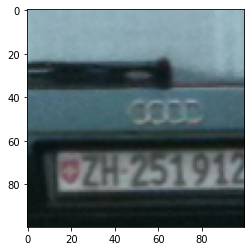

In [ ]:
import requests
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img = mpimg.imread("./1.jpg", 0)
plt.imshow(img)

phone_image = tf.reshape(img, [-1, PATCH_HEIGHT, PATCH_WIDTH, 3])
print(phone_image.get_shape())
print(phone_image)

tf.Tensor(284980400.0, shape=(), dtype=float32)
Total variation(y) -  tf.Tensor(3.7262454, shape=(), dtype=float32)  Total variation(x) -  tf.Tensor(2.4772062, shape=(), dtype=float32)


<function destroyAllWindows>

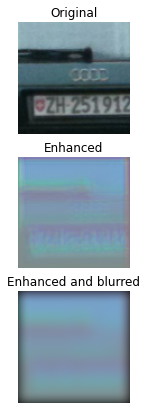

In [ ]:
#Gaussian Blur
import cv2
import matplotlib.pyplot as plt

#create figure 
fig = plt.figure(figsize=(10, 7)) 

img = plt.imread('./1.jpg')
img_blur = cv2.GaussianBlur(img, (21, 21), 3)

#plt.imshow(img_blur)

I = np.float32(np.reshape(img, [1, 100*100*3]))
phone_image = tf.reshape(I, [-1, PATCH_HEIGHT, PATCH_WIDTH, 3])
enhanced = residualnetwork(phone_image)

enhanced_blur = blur(enhanced)
img_blur_2 = blur(phone_image)
loss_color = tf.reduce_sum(tf.pow(enhanced_blur - img_blur_2, 2))

print(loss_color)

fig.add_subplot(3, 1, 1) 
plt.imshow(img)
plt.axis('off') 
plt.title("Original") 

fig.add_subplot(3, 1, 2)
plt.imshow(tf.squeeze(enhanced))
plt.axis('off') 
plt.title("Enhanced") 

fig.add_subplot(3, 1, 3)
plt.imshow(tf.squeeze(enhanced_blur))
plt.axis('off') 
plt.title("Enhanced and blurred") 

batch_shape = (batch_size, PATCH_WIDTH, PATCH_HEIGHT, 3)
#y -> vertical axis, x -> horizontal axis
tv_y_size = tensor_size(enhanced[:,1:,:,:])
tv_x_size = tensor_size(enhanced[:,:,1:,:])
#this is done to measure the difference between the values of the current pixel and the neighbouring pixel and find the l2 norm (output = sum(t ** 2) / 2)
y_tv = tf.nn.l2_loss(enhanced[:,1:,:,:] - enhanced[:,:batch_shape[1]-1,:,:])
x_tv = tf.nn.l2_loss(enhanced[:,:,1:,:] - enhanced[:,:,:batch_shape[2]-1,:])
loss_tv = 2 * (x_tv/tv_x_size + y_tv/tv_y_size) / batch_size

print("Total variation(y) - ", y_tv, " Total variation(x) - ", x_tv)

cv2.waitKey(0)
cv2.destroyAllWindows

In [ ]:
A = tf.reshape([[2,1,24],[4,5,6],[67,34,56]],[3,3,1])
print(A)

print(tf.argmax(A,1))

tf.Tensor(
[[[ 2]
  [ 1]
  [24]]

 [[ 4]
  [ 5]
  [ 6]]

 [[67]
  [34]
  [56]]], shape=(3, 3, 1), dtype=int32)
tf.Tensor(
[[2]
 [2]
 [0]], shape=(3, 1), dtype=int64)


In [ ]:
print(tf.constant(0.01, shape=[1024]))

A = tf.reshape([1,2,3],(3,1))
print(A)

B = tf.reshape([4,5,6], (3,1))
print(B)

print(tf.concat([A, B], 1))

tf.Tensor([0.01 0.01 0.01 ... 0.01 0.01 0.01], shape=(1024,), dtype=float32)
tf.Tensor(
[[1]
 [2]
 [3]], shape=(3, 1), dtype=int32)
tf.Tensor(
[[4]
 [5]
 [6]], shape=(3, 1), dtype=int32)
tf.Tensor(
[[1 4]
 [2 5]
 [3 6]], shape=(3, 2), dtype=int32)


# Export model

In [ ]:
tf.compat.v1.reset_default_graph()

def freeze_graph(input_checkpoint, output_graph):
  '''
  :param input_checkpoint: xxx.ckpt (Do not add the following xxx.ckpt.data, go to ckpt!)
  :param output_graph: PB model save path
  :return:
  '''

  # checkpoint = tf.train.get_checkpoint_state(model_folder) #Check if the status of the ckpt file is available in the directory.
  # input_checkpoint = checkpoint.model_checkpoint_path #  ckptFile Path

  # Specify the node name of the output, the node name must be the node existing in the original model
  output_node_names = "generator/add_32" #Model input node, customize according to the situation
  saver = tf.compat.v1.train.import_meta_graph(input_checkpoint + '.meta', clear_devices=True)
  graph = tf.compat.v1.get_default_graph() # Get the default map
  input_graph_def = graph.as_graph_def()  # return a serialized graph representing the current graph

  with tf.compat.v1.Session() as sess:
    saver.restore(sess, input_checkpoint) #   and get the data
    output_graph_def = tf.compat.v1.graph_util.convert_variables_to_constants(  #Model persistence, fixed variable values
           sess=sess,
           input_graph_def=input_graph_def,# equal to: sess.graph_def
           output_node_names=output_node_names.split(","))# If there are multiple output nodes, separated by commas

    with tf.compat.v1.gfile.GFile(output_graph, "wb") as f: #Save model
      f.write(output_graph_def.SerializeToString())
      
    print("%d ops in the final graph." % len(output_graph_def.node)) #Get the current graph has several operation nodes


input_checkpoint = 'drive/MyDrive/Innovation_Practices_Lab/models/sony_iteration_9000.ckpt'
out_graph = 'drive/MyDrive/Innovation_Practices_Lab/saved_model/sony_new.pb'
freeze_graph(input_checkpoint, out_graph)

INFO:tensorflow:Restoring parameters from drive/MyDrive/Innovation_Practices_Lab/models/sony_iteration_9000.ckpt


INFO:tensorflow:Restoring parameters from drive/MyDrive/Innovation_Practices_Lab/models/sony_iteration_9000.ckpt


Instructions for updating:
Use `tf.compat.v1.graph_util.convert_variables_to_constants`


Instructions for updating:
Use `tf.compat.v1.graph_util.convert_variables_to_constants`


Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`


Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`


239 ops in the final graph.


In [ ]:
%tensorflow_version 1.x
!pip install tensorboardcolab

import tensorflow as tf
#from tensorflow.summary import FileWriter
from tensorboardcolab import *
sess = tf.compat.v1.Session()


tf.compat.v1.train.import_meta_graph("drive/MyDrive/Innovation_Practices_Lab/test_models/sony_test_iteration_9000.ckpt.meta")
graph = tf.compat.v1.get_default_graph() 
#FileWriter("__tb", sess.graph)

tbc = TensorBoardColab() # To create a tensorboardcolab object it will automatically creat a link
writer = tbc.get_writer() # To create a FileWriter
writer.add_graph(graph) # add the graph 
writer.flush()

Wait for 8 seconds...
TensorBoard link:
http://4d26639f8a85.ngrok.io



# Loading the pb (ProtoBuf) file

In [ ]:
tf.compat.v1.reset_default_graph()

def load_pb(path_to_pb):
  with tf.compat.v1.gfile.GFile(path_to_pb, "rb") as f:
    graph_def = tf.compat.v1.GraphDef()
    graph_def.ParseFromString(f.read())
  with tf.compat.v1.Graph().as_default() as graph:
    tf.compat.v1.import_graph_def(graph_def, name='')
    return graph

pb_graph = load_pb('drive/MyDrive/Innovation_Practices_Lab/saved_model/sony_test_new.pb')

# for op in pb_graph.get_operations():
#   print(op.name)

with tf.compat.v1.Session(graph=pb_graph) as sess:

  #get all available image resolutions
  res_sizes = get_resolutions()

  #get the specified image resolution
  IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_SIZE = get_specified_res(res_sizes, phone, resolution)

  input = sess.graph.get_tensor_by_name('Placeholder:0')
  output = sess.graph.get_tensor_by_name('generator/add_32:0')
  
  #print(input, " ", output)

  #get all available image resolutions
  res_sizes = get_resolutions()

  #get the specified image resolution
  IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_SIZE = get_specified_res(res_sizes, phone, resolution)

  image_main =  np.float16(np.array(Image.fromarray(imageio.imread(dped_dir + "sony/test_data/full_size_test_images/6.jpg")).resize([res_sizes[phone][1], res_sizes[phone][0]]))) / 255


  #image_main = resize(image_main, (100, 100) ,anti_aliasing=True)
  #image = np.reshape(image_main, [1,30000])
  image = np.reshape(image_main, [1,IMAGE_SIZE])

  #get enhanced image

  enhanced = sess.run(output, {input:image})

  #enhanced_image = np.reshape(enhanced, [100, 100, 3])
  enhanced_image = np.reshape(enhanced, [IMAGE_HEIGHT, IMAGE_WIDTH, 3])

  before_after = np.hstack((image_main, enhanced_image))

  #save the result as .png image

  imageio.imwrite("drive/MyDrive/Innovation_Practices_Lab/visual_results/protobuf_test_before_after.png", before_after)

# Converting pb file to tflite format for android and iOS app

In [ ]:
saved_model_dir = 'drive/MyDrive/Innovation_Practices_Lab/saved_model/sony_test_new.pb'

#input = sess.graph.get_tensor_by_name('Placeholder:0')
#output = sess.graph.get_tensor_by_name('generator/add_32:0')
  
converter = tf.compat.v1.lite.TFLiteConverter.from_frozen_graph(saved_model_dir, ['Placeholder'], ['generator/add_32'])
tflite_model = converter.convert()
open("drive/MyDrive/Innovation_Practices_Lab/saved_model/sony_converted_model.tflite", "wb").write(tflite_model)

1625652

# Converting pb file to json for deploying on web

In [ ]:
!pip install tensorflowjs

!tensorflowjs_converter --input_format=tf_frozen_model --output_node_names='generator/add_32' --saved_model_tags=serve ./drive/MyDrive/Innovation_Practices_Lab/saved_model/sony_new.pb ./drive/MyDrive/Innovation_Practices_Lab/saved_model/sony_converted_model_100_cross_100

     |████████████████████████████████| 71kB 3.3MB/s 
     |████████████████████████████████| 112kB 8.1MB/s 
  Found existing installation: tensorflow-hub 0.11.0
    Uninstalling tensorflow-hub-0.11.0:
      Successfully uninstalled tensorflow-hub-0.11.0
2021-03-23 18:45:29.065494: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-03-23 18:45:31.231595: I tensorflow/core/grappler/optimizers/meta_optimizer.cc:928] Optimization results for grappler item: graph_to_optimize
  debug_stripper: debug_stripper did nothing. time = 0.022ms.
  model_pruner: Graph size after: 191 nodes (-48), 218 edges (-48), time = 5.385ms.
  constant_folding: Graph size after: 191 nodes (0), 218 edges (0), time = 3.916ms.
  arithmetic_optimizer: Graph size after: 191 nodes (0), 218 edges (0), time = 2.95ms.
  dependency_optimizer: Graph size after: 183 nodes (-8), 210 edges (-8), time = 1.083ms.
  model_pruner: Graph size after: 183 nodes (

# Hosting on Web

In [ ]:
tf.compat.v1.reset_default_graph()

def enhance_image(input_image, height, width):

  with tf.compat.v1.Session() as sess:

    #get the specified image resolution
    if height > 2000 or width > 2000:
      IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_SIZE = height // 2, width // 2, (height // 2)*(width // 2)*3

    else:  
      IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_SIZE = height, width, height*width*3

    # create placeholders for input images
    x_ = tf.compat.v1.placeholder(tf.float32, [None, IMAGE_SIZE])
    x_image = tf.reshape(x_, [-1, IMAGE_HEIGHT, IMAGE_WIDTH, 3])

    #generate enhanced image
    enhanced = residualnetwork(x_image)

    #load pre-trained model
    saver = tf.compat.v1.train.Saver()
    saver.restore(sess, "drive/MyDrive/Innovation_Practices_Lab/models/iphone_iteration_9000.ckpt")
    #orig model - saver.restore(sess, "drive/MyDrive/Innovation_Practices_Lab/models/original_models/iphone/iphone_orig")

    image = np.float32(np.array(input_image.resize([IMAGE_WIDTH, IMAGE_HEIGHT]))) / 255

    #imageio.imwrite("drive/MyDrive/Innovation_Practices_Lab/visual_results/input.png", image)

    image_crop_2d = np.reshape(image, [1, IMAGE_SIZE])

    #get enhanced image

    enhanced_2d = sess.run(enhanced, feed_dict={x_: image_crop_2d})
    enhanced_image = np.reshape(enhanced_2d, [IMAGE_HEIGHT, IMAGE_WIDTH, 3])

    #save the results as .png images

    before_after = np.hstack((image, enhanced_image))

    #imageio.imwrite("drive/MyDrive/Innovation_Practices_Lab/visual_results/enhanced.png", enhanced_image)
    imageio.imwrite("drive/MyDrive/Innovation_Practices_Lab/visual_results/enhanced_image_before_after.png", before_after)

    new_enhanced_image = cv2.normalize(enhanced_image, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)

    img = Image.fromarray(new_enhanced_image)
    rawBytes = io.BytesIO()
    img.save(rawBytes, "JPEG")
    rawBytes.seek(0)
    img_base64 = base64.b64encode(rawBytes.read())

    return jsonify({'status':str(img_base64)})

In [ ]:
!pip install flask
!pip install flask-ngrok

import flask
import os,io,sys
from flask import Flask, render_template , request , jsonify
import base64

from flask_ngrok import run_with_ngrok

app = Flask(__name__, template_folder='./drive/MyDrive/Innovation_Practices_Lab/Flask_web/templates', static_folder='./drive/MyDrive/Innovation_Practices_Lab/Flask_web/static')
run_with_ngrok(app)   #starts ngrok when the app is run

@app.route("/")
def home():
  return render_template('index.html')

@app.route('/test' , methods=['GET','POST'])
def test():
	print("log: got at test" , file=sys.stderr)
	return jsonify({'status':'success'})
  
@app.route('/predict', methods=['GET','POST'])
def predict():
  file = request.files['image'].read()
  npimg = np.frombuffer(file,np.uint8)
  input_image = cv2.imdecode(npimg,cv2.IMREAD_COLOR) #OpenCV uses BGR
  input_image = cv2.cvtColor(input_image , cv2.COLOR_BGR2RGB)
  #print(input_image.shape)
  #print(Image.fromarray(input_image))
  #print(Image.fromarray(input_image).resize([2592, 1944]))
  response = enhance_image(Image.fromarray(input_image),input_image.shape[0], input_image.shape[1])
  return response

@app.after_request
def after_request(response):
  print("log: setting cors" , file = sys.stderr)
  response.headers.add('Access-Control-Allow-Origin', '*')
  response.headers.add('Access-Control-Allow-Headers', 'Content-Type,Authorization')
  response.headers.add('Access-Control-Allow-Methods', 'GET,PUT,POST,DELETE')
  
  return response

app.run()

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)


 * Running on http://8e7f247bca70.ngrok.io
 * Traffic stats available on http://127.0.0.1:4040


log: setting cors
127.0.0.1 - - [10/Apr/2021 17:41:59] "GET / HTTP/1.1" 200 -
log: setting cors
log: setting cors
127.0.0.1 - - [10/Apr/2021 17:42:00] "GET /static/css/index.css HTTP/1.1" 200 -
127.0.0.1 - - [10/Apr/2021 17:42:00] "GET /static/js/index.js HTTP/1.1" 200 -
log: setting cors
127.0.0.1 - - [10/Apr/2021 17:42:01] "GET /favicon.ico HTTP/1.1" 404 -


INFO:tensorflow:Restoring parameters from drive/MyDrive/Innovation_Practices_Lab/models/iphone_iteration_9000.ckpt


log: setting cors
127.0.0.1 - - [10/Apr/2021 17:44:34] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [10/Apr/2021 17:44:34] "POST /predict HTTP/1.1" 200 -
log: setting cors
127.0.0.1 - - [10/Apr/2021 17:46:53] "GET / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [10/Apr/2021 17:46:53] "GET / HTTP/1.1" 200 -


INFO:tensorflow:Restoring parameters from drive/MyDrive/Innovation_Practices_Lab/models/iphone_iteration_9000.ckpt


INFO:tensorflow:Restoring parameters from drive/MyDrive/Innovation_Practices_Lab/models/iphone_iteration_9000.ckpt
log: setting cors
127.0.0.1 - - [10/Apr/2021 17:47:22] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [10/Apr/2021 17:47:22] "POST /predict HTTP/1.1" 200 -
log: setting cors
127.0.0.1 - - [10/Apr/2021 17:49:09] "GET / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [10/Apr/2021 17:49:09] "GET / HTTP/1.1" 200 -


INFO:tensorflow:Restoring parameters from drive/MyDrive/Innovation_Practices_Lab/models/iphone_iteration_9000.ckpt


INFO:tensorflow:Restoring parameters from drive/MyDrive/Innovation_Practices_Lab/models/iphone_iteration_9000.ckpt
log: setting cors
127.0.0.1 - - [10/Apr/2021 17:49:24] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [10/Apr/2021 17:49:24] "POST /predict HTTP/1.1" 200 -
log: setting cors
127.0.0.1 - - [10/Apr/2021 17:51:05] "GET / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [10/Apr/2021 17:51:05] "GET / HTTP/1.1" 200 -


INFO:tensorflow:Restoring parameters from drive/MyDrive/Innovation_Practices_Lab/models/iphone_iteration_9000.ckpt


INFO:tensorflow:Restoring parameters from drive/MyDrive/Innovation_Practices_Lab/models/iphone_iteration_9000.ckpt
log: setting cors
127.0.0.1 - - [10/Apr/2021 17:51:15] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [10/Apr/2021 17:51:15] "POST /predict HTTP/1.1" 200 -
